### Import Libraries and TensforFlow Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, shutil, pickle, random, gc
from collections import Counter
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.metrics import (confusion_matrix, classification_report, 
                             accuracy_score)

import tensorflow as tf
from keras import models, layers, optimizers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import Model

from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import (Dense, Dropout, Activation, Input, 
                                     GlobalAveragePooling2D, average, add, 
                                     maximum)

from tqdm.notebook import tqdm

### Recreate Model and load weights

#### Parameters

In [2]:
N_CLASSES = 5
IMAGE_SIZE = 512
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
EPOCHS = 8
TARGET_SIZE = INPUT_SHAPE
DROPOUT = 0.4

#### Loading models of EfficientNetB3

In [3]:
def create_model():
    conv_base = EfficientNetB3(weights='imagenet',
                               include_top=False,
                               input_shape=(INPUT_SHAPE))

    inputs = Input(shape=INPUT_SHAPE)
    conv_base = conv_base(inputs)
    pooling = layers.GlobalAveragePooling2D()(conv_base)
    dropout = layers.Dropout(DROPOUT)(pooling)
    outputs = Dense(N_CLASSES, activation="softmax")(dropout)
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [4]:
models = []

model_1 = create_model()
model_2 = create_model()
model_3 = create_model()
model_4 = create_model()
model_5 = create_model()

model_1.load_weights("efficientnetb3-CV-ls_0.3_oof_0.h5")
model_2.load_weights("efficientnetb3-CV-ls_0.3_oof_1.h5")
model_3.load_weights("efficientnetb3-CV-ls_0.3_oof_2.h5")
model_4.load_weights("efficientnetb3-CV-ls_0.3_oof_3.h5")
model_5.load_weights("efficientnetb3-CV-ls_0.3_oof_4.h5")

model_1._name = 'model_1'
model_2._name = 'model_2'
model_3._name = 'model_3'
model_4._name = 'model_4'
model_5._name = 'model_5'

In [5]:
models = [model_1, model_2, model_3, model_4, model_5]

#### Test Time Augmentation

In [6]:
test_time_augmentation_layers = tf.keras.Sequential(
    [layers.experimental.preprocessing.CenterCrop(512, 512),
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomZoom((-0.3, 0.3)),
     layers.experimental.preprocessing.RandomContrast((0.5,0.5)),
     layers.experimental.preprocessing.Normalization()]
)

### Predict on Sample Test Set

#### Helper Functions

In [7]:
def scan_over_image(img_path, crop_size=512):
    '''
    Will extract 512x512 images covering the whole original image
    with some overlap between images
    '''
    
    img = Image.open(img_path)
    img_height, img_width = img.size
    img = np.array(img)
    
    y = random.randint(0,img_height-crop_size)
    x = random.randint(0,img_width-crop_size)

    x_img_origins = [0,img_width-crop_size]
    y_img_origins = [0,img_height-crop_size]
    img_list = []
    for x in x_img_origins:
        for y in y_img_origins:
            img_list.append(img[x:x+crop_size , y:y+crop_size,:])
  
    return np.array(img_list)

In [8]:
def predict_and_vote(image_filename, folder, TTA_runs=4):
    """
    Run all models over 4 local areas of the given image,
    before making a decision depending on the most predicted
    disease.
    """
    
    model_predictions = []
    
    for model in models:
        # apply TTA to each of the 4 images and sum all predictions for each 
        # local image
        localised_predictions = []
        local_image_list = scan_over_image(folder+image_filename)
        for local_image in local_image_list:
            local_image = tf.expand_dims(local_image,0)
            augmented_images = [test_time_augmentation_layers(local_image) 
                                for i in range(TTA_runs)]
            predictions = model.predict(np.array(augmented_images[0]))
            localised_predictions.append(np.sum(predictions, axis=0))

        # sum predictions from all 4 images and retrieve the index of the 
        # highest value
        global_predictions = np.sum(np.array(localised_predictions),axis=0)
        model_predictions += [global_predictions]
        
    global_predictions = np.sum(np.array(model_predictions),axis=0)
    final_prediction = np.argmax(global_predictions)
    
    return final_prediction

In [9]:
def run_predictions_over_image_list(image_list, folder):
    """
    Accepts image filenames and folder, iterates prediction over all images,
    and returns the predictions.
    """
    
    predictions = []
    with tqdm(total=len(image_list)) as pbar:
        for image_filename in image_list:
            pbar.update(1)
            predictions.append(predict_and_vote(image_filename, folder, 4))
    return predictions

#### Run Predictions

In [10]:
src_folder = '../cassava-leaf-disease-classification/train_images/'
oof = pd.read_csv('oof.csv', usecols=['label', 'image_id'])
oof.rename(columns={'label':'actual'}, inplace=True)
oof.head()

,image_id,actual
0,2615227158.jpg,4
1,1277648239.jpg,3
2,2305895487.jpg,3
3,336299725.jpg,2
4,1951270318.jpg,2


In [11]:
oof["prediction"] = run_predictions_over_image_list(oof["image_id"], 
                                                    src_folder)

  0%|          | 0/4279 [00:00<?, ?it/s]

### Evaluation

In [81]:
labels = ['Bacterial Blight (CBB)',
          'Brown Streak Disease (CBSD)',
          'Green Mottle (CGM)',
          'Mosaic Disease (CMD)',
          'Healthy']

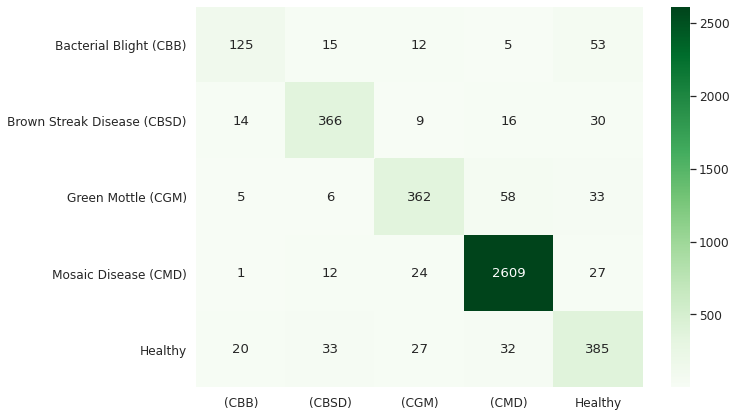

In [104]:
df_cm = pd.DataFrame(conf, index = labels,
                  columns = [labels[i].split(' ')[-1] for i in range(5)])
plt.figure(figsize = (10,7))

sns. set(font_scale=1.1)
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Greens')
# plt.savefig('conf.jpg', dpi=300, bbox_inches = 'tight')

In [100]:
report = pd.DataFrame.from_dict(classification_report(oof['actual'], 
                                                      oof['prediction'],
                                                      target_names=labels,
                                                      output_dict=True))
# report.to_csv('report.csv')
report

,Bacterial Blight (CBB),Brown Streak Disease (CBSD),Green Mottle (CGM),Mosaic Disease (CMD),Healthy,accuracy,macro avg,weighted avg
precision,0.757576,0.847222,0.834101,0.959191,0.729167,0.899042,0.825451,0.897632
recall,0.595238,0.841379,0.780172,0.976057,0.774648,0.899042,0.793499,0.899042
f1-score,0.666667,0.844291,0.806236,0.967551,0.751220,0.899042,0.807193,0.897635
support,210.000000,435.000000,464.000000,2673.000000,497.000000,0.899042,4279.000000,4279.000000
